**Название проекта:** Определение рыночной стоимости автомобилей с пробегом

**Описание исследования:** Сервис продажи автомобилей «Не бит, не крашен» разрабатывает приложение для оценки рыночной стоимости автомобилей. Это позволит клиентам быстро получать информацию о цене их транспортного средства, что повысит доверие к сервису и привлечёт новых пользователей.
В рамках проекта требуется построить модель машинного обучения, которая на основе технических характеристик, пробега, марки и других параметров автомобиля предсказывает его стоимость. Ключевые требования заказчика:

1. Высокое качество предсказания (RMSE < 2500).
2. Минимизация времени обучения и предсказания модели.

**Цель исследования:** Разработать модель для определения рыночной стоимости автомобилей, которая обеспечивает точность прогноза (RMSE < 2500) и эффективность по времени выполнения.

**Задачи исследования:** 
1. Загрузить и изучить данные из файла autos.csv.
2. Провести обработку данных: удаление неинформативных признаков, корректировка аномальных значений, преобразование категориальных переменных. 
3. Разделить данные на обучающую, валидационную и тестовую выборки.
4. Обучить модели: LightGBM с оптимизацией гиперпараметров и альтернативные модели (DecisionTreeRegressor, LinearRegression).
5. Оценить модели по критериям:RMSE на валидационной выборке и время обучения и предсказания.
6. Проверить лучшую модель на тестовой выборке.

**Исходные данные:**
Файл autos.csv содержит следующие признаки:

Признаки:

DateCrawled — дата скачивания анкеты.

VehicleType — тип кузова.

RegistrationYear — год регистрации.

Gearbox — тип коробки передач.

Power — мощность (л. с.).

Model — модель автомобиля.

Kilometer — пробег (км).

RegistrationMonth — месяц регистрации.

FuelType — тип топлива.

Brand — марка автомобиля.

Repaired — наличие ремонта в истории.

DateCreated — дата создания анкеты.

NumberOfPictures — количество фотографий.

PostalCode — почтовый индекс.

LastSeen — дата последней активности.

Целевой признак:

Price — цена автомобиля (евро).

**Импорт библиотек**

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest, f_classif

pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42
TEST_SIZE = 0.25

**Функции**

In [3]:
def prepare(df):
    df.columns = df.columns.str.lower()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.lower()
    nulls = df.isna().sum()
    print(f'количество пропусков в датафрейме:')
    print(nulls)
    
    dupls = df.duplicated().sum()
    print(f'количество явных дубликатов = {dupls}')
    if dupls > 0:
        df.drop_duplicates(inplace = True)
        print(f'количество явных дубликатов после удаления = {df.duplicated().sum()}')
    
    for col in df.select_dtypes('object').columns:
        print(f'Уникальные значения в {col} :')
        print(df[col].unique())
    
    return df

## Предварительный анализ данных

### Загрузка данных

In [4]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.shape

(354369, 16)

*Промежуточный вывод:*

1. Был загружен датафрейм
2. Рзамер датафрейма: 354369 строк и 16 столбцов
3. В датафрейме присутствуют пропуски
4. Нужно изменить тип для LastSeen, DateCreated и DateCrawled 

### Предобработка данных

In [7]:
prepare(df).head()

количество пропусков в датафрейме:
datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64
количество явных дубликатов = 4
количество явных дубликатов после удаления = 0
Уникальные значения в datecrawled :
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения в vehicletype :
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения в gearbox :
['manual' 'auto' nan]
Уникальные значения в model :
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'pa

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


1. Пропуски будут заполнены в паплайне в пункте 2
2. Были удалены явные дубликаты
3. Неявных дубликатов не было обнаружено


In [8]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'], errors='coerce')

In [9]:
df['lastseen'] = pd.to_datetime(df['lastseen'], errors='coerce')

In [10]:
df['datecreated'] = pd.to_datetime(df['datecreated'], errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

*Промежуточный вывод:*

1. Были удалены явные дубликаты
2. Неявных дубликатов не было обнаружено
3. Пропуски были обнаружены
4. Изменен тип у признаков lastseen, datecreated и datecrawled
5. Названия столбцов и значений были приведены к нижнему регистру

### Исследовательский анализ 

In [12]:
numeric_columns = df.select_dtypes(include=['int64']).columns

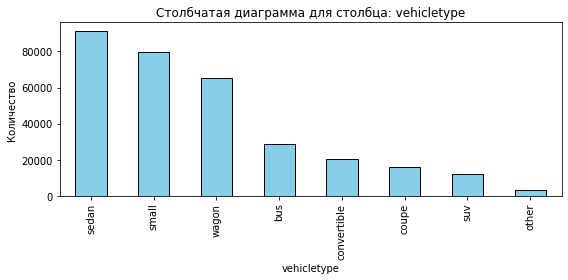

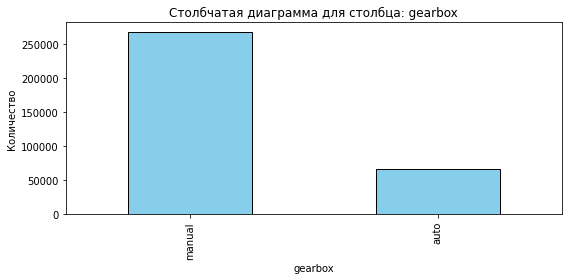

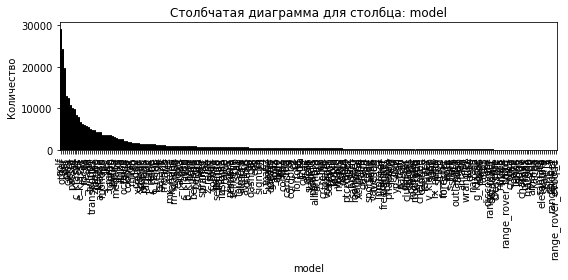

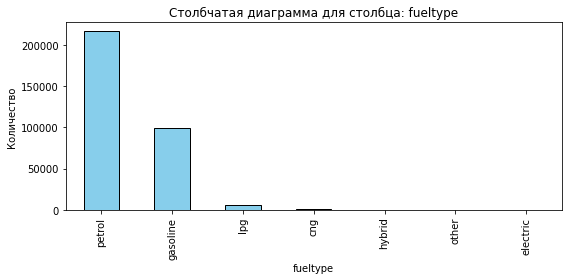

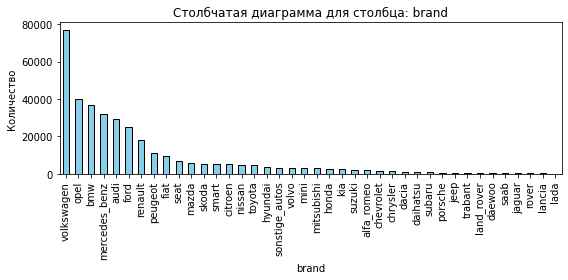

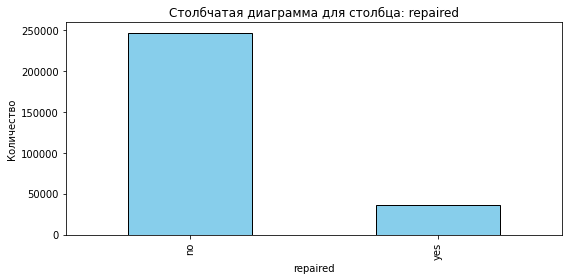

In [13]:
for column in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    df[column].value_counts().plot(kind='bar', color = 'skyblue', edgecolor = 'black')
    plt.title(f'Столбчатая диаграмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

*Промежуточный вывод:*

1. Больше всего седанов
2. Больше всего ТС с МКПП
3. Больше всего ТС, использующих бензин
4. Больше всего volkswagen
5. Большинство ТС не ремонтировались (после ДТП)

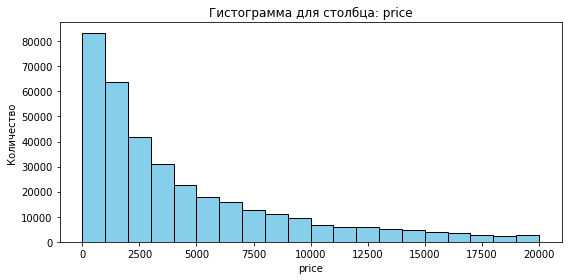

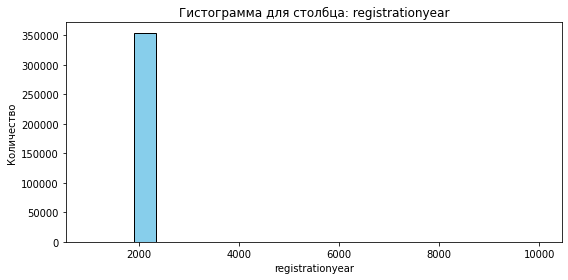

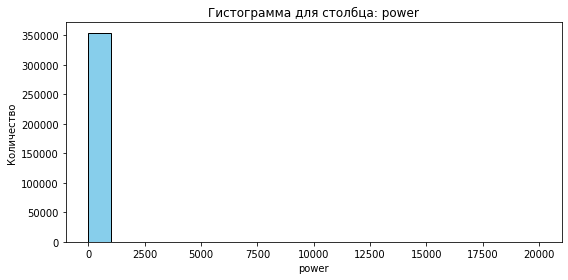

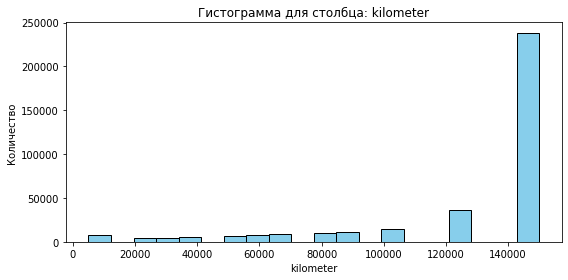

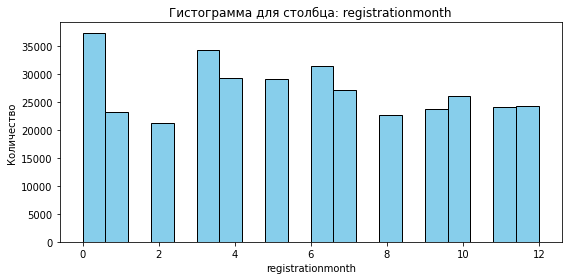

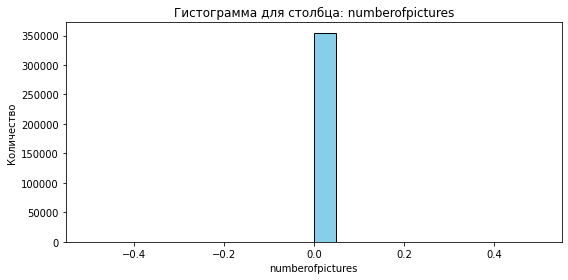

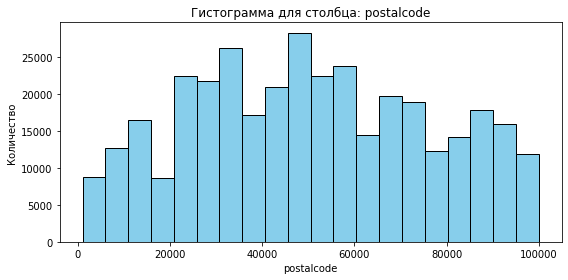

In [15]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    df[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

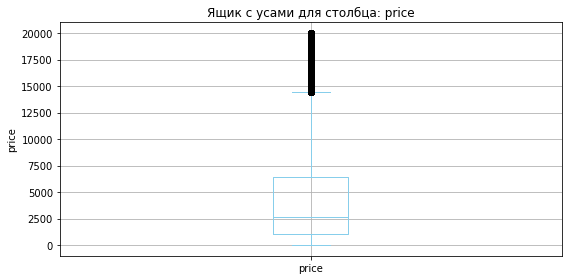

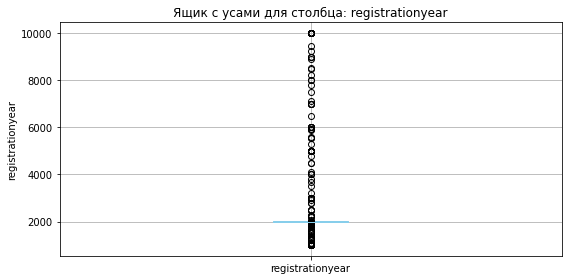

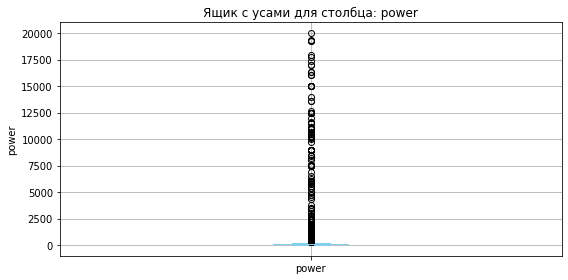

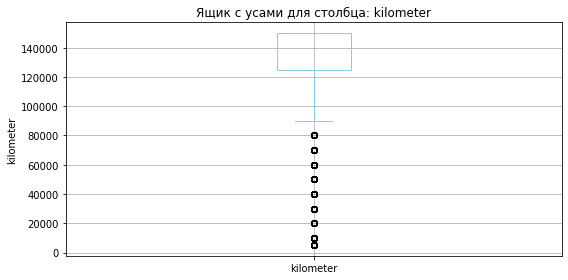

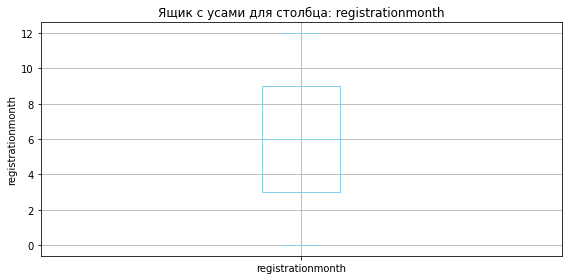

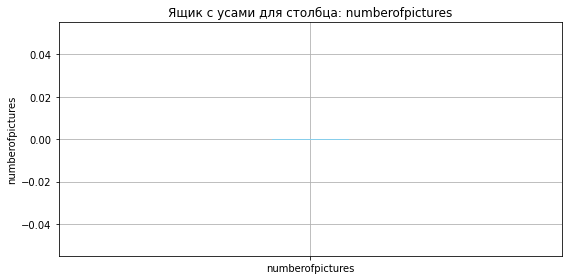

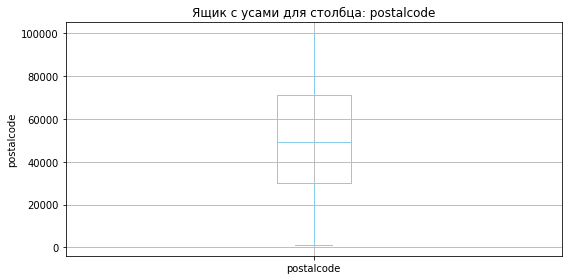

In [16]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    df.boxplot(column=column, color='skyblue')
    plt.title(f'Ящик с усами для столбца: {column}')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

Нужно подробнее разобраться с некоторыми признаками

In [17]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Признак numberofpictures можно удалить, так как он является безсполезным (везде значение 0)

В registrationyear присутствуют аномалии: слишком маленькие и слишком большие значения, оставим только наиболее частые от 1950 до 2025

Нужно ограничить цену, чтобы она была >0

То же самое с мощностью, но еще добавить верхнее приблизительное ограничение (до 600) и построить новые гистограммы для более детального исследования

In [18]:
df['price'].quantile(0.15)

650.0

In [19]:
df = df.drop(columns=['numberofpictures'])
df = df.query('registrationyear > 1950 and registrationyear < 2016 and price > 650 and power > 0 and power < 600')

In [20]:
df['datecrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [21]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,261067.000000,261067.000000,261067.000000,261067.000000,261067.000000,261067.000000
mean,5404.288443,2003.126649,125.052213,126886.239931,6.114564,51591.347171
std,4609.479097,6.208263,54.104517,37318.072635,3.530109,25713.110998
min,655.000000,1951.000000,1.000000,5000.000000,0.000000,1067.000000
25%,1800.000000,2000.000000,86.000000,125000.000000,3.000000,31224.000000
50%,3800.000000,2004.000000,116.000000,150000.000000,6.000000,50827.000000
75%,7700.000000,2007.000000,150.000000,150000.000000,9.000000,72342.000000
max,20000.000000,2015.000000,585.000000,150000.000000,12.000000,99998.000000


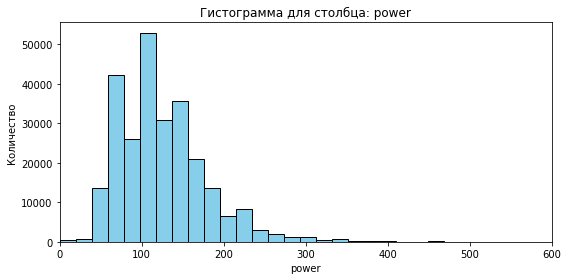

In [22]:
plt.figure(figsize=(8, 4))
df['power'].plot(kind='hist', bins=30, color = 'skyblue',edgecolor='black')
plt.title(f'Гистограмма для столбца: power')
plt.xlabel('power')
plt.ylabel('Количество')
plt.xlim(0, 600)
plt.tight_layout()
plt.show()

Можем поставить для power нижнюю границу в 50 и верхнюю в 230 л.с.

In [23]:
df = df.query('power > 50 and power < 230')

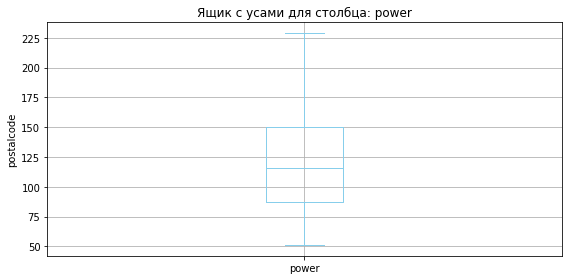

In [24]:
plt.figure(figsize=(8, 4))
df.boxplot(column='power', color='skyblue')
plt.title(f'Ящик с усами для столбца: power')
plt.ylabel(column)
plt.tight_layout()
plt.show()

In [25]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,242465.000000,242465.000000,242465.000000,242465.000000,242465.000000,242465.000000
mean,5179.888297,2003.284280,119.509286,126713.587528,6.106250,51606.574598
std,4397.111096,5.960159,41.242691,37408.868474,3.525564,25703.387678
min,655.000000,1951.000000,51.000000,5000.000000,0.000000,1067.000000
25%,1800.000000,2000.000000,87.000000,125000.000000,3.000000,31228.000000
50%,3650.000000,2004.000000,116.000000,150000.000000,6.000000,50829.000000
75%,7250.000000,2007.000000,150.000000,150000.000000,9.000000,72294.000000
max,20000.000000,2015.000000,229.000000,150000.000000,12.000000,99998.000000


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242465 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        242465 non-null  datetime64[ns]
 1   price              242465 non-null  int64         
 2   vehicletype        239592 non-null  object        
 3   registrationyear   242465 non-null  int64         
 4   gearbox            239081 non-null  object        
 5   power              242465 non-null  int64         
 6   model              235201 non-null  object        
 7   kilometer          242465 non-null  int64         
 8   registrationmonth  242465 non-null  int64         
 9   fueltype           233623 non-null  object        
 10  brand              242465 non-null  object        
 11  repaired           213008 non-null  object        
 12  datecreated        242465 non-null  datetime64[ns]
 13  postalcode         242465 non-null  int64   

Сомнительные признаки - datecrawled, datecreated, lastseen - они не важны в оценке стоимости автомобиля, так как не являются техническими характеристиками ТС

Их можно удалить

Также можно удалить признак registrationmonth, так как признака registrationyear будет достаточно

In [27]:
 df = df.drop(columns=['datecrawled', 'datecreated', 'lastseen', 'registrationmonth'])

*Вывод*

1. Больше всего седанов
2. Больше всего ТС с МКПП
3. Больше всего ТС, использующих бензин
4. Больше всего volkswagen
5. Большинство ТС не ремонтировались (после ДТП)
6. Ограничение цены >650
7. Ограничение года регистрации от 1950 до 2016
8. Ограничение мощности от 50 до 230
9. Были удалены признаки numberofpictures, datecrawled, datecreated, lastseen, registrationmonth

## Подготовка данных

In [28]:
df_new = df.drop('model', axis = 1)

In [29]:
X = df_new.drop('price', axis=1)
y = df_new['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE)

col_ohe = ['vehicletype', 'gearbox', 'fueltype', 'brand', 'repaired']
num_col = ['registrationyear', 'power', 'kilometer', 'postalcode']

col_ohe

['vehicletype', 'gearbox', 'fueltype', 'brand', 'repaired']

In [30]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, col_ohe),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        #('feature_selection', SelectKBest(score_func=f_classif)),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

*Вывод:*

Создан паплайн с кодировщиком OneHotEncoder и маштабированием с помощью StandardScaler

## Обучение моделей

In [31]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    return rmse

rmse_score = make_scorer(rmse, greater_is_better=False)

In [32]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': [500, 1000],
        #'feature_selection__k': [4, 6, 'all'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        #'feature_selection__k': [4, 6, 'all'],
        'preprocessor__num': [StandardScaler()]  
    },
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE, metric = 'rmse')],
        'models__max_depth': [10, 500],
        'preprocessor__num': [StandardScaler()]
        #'feature_selection__k': [4, 6, 'all']
    }
]

In [33]:
grid = GridSearchCV(pipe_final, 
                    param_distributions, 
                    cv=5, 
                    n_jobs=-1,
                    scoring=rmse_score
)

In [34]:
grid.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['vehicletype',
                                                                          'gearbox',
                                                                          'fueltype',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['regi...
                          'models__min_samples_split': [500, 1000],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler()]},
                         {'models': [LGBMRegressor(metric='rmse',
                                                   random_state=42)],
                          'models__max_depth': [10, 500],
                          'preprocessor__num': [StandardScaler()]}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [35]:
model = grid.best_estimator_.steps[1][1]
grid.best_score_ * -1

1603.3550359233384

*Вывод:*

1. Были обучены модели: DecisionTreeRegressor, LinearRegression, LGBMRegressor
2. Для каждой модели подобраны гиперпараметры
3. Получена модель с лучшим показанием метрики:  LGBMRegressor(max_depth=500, metric='rmse', random_state=42) с RMSE = 1603
4. Создана метрика rmse

## Анализ моделей

In [36]:
results = grid.cv_results_
results_df = pd.DataFrame(results)

ranking_columns = ['params', 'mean_test_score', 'rank_test_score']
ranking_df = results_df[ranking_columns].sort_values(by='rank_test_score')

print("Рейтинг моделей:")
display(ranking_df.head(10))

Рейтинг моделей:


,params,mean_test_score,rank_test_score
20,"{'models': LGBMRegressor(metric='rmse', random_state=42), 'models__max_depth': 500, 'preprocessor__num': StandardScaler()}",-1603.355036,1
19,"{'models': LGBMRegressor(metric='rmse', random_state=42), 'models__max_depth': 10, 'preprocessor__num': StandardScaler()}",-1608.452507,2
17,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 1000, 'preprocessor__num': 'passthrough'}",-2401.470232,3
16,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 1000, 'preprocessor__num': MinMaxScaler()}",-2401.470232,3
15,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 1000, 'preprocessor__num': StandardScaler()}",-2401.470232,3
14,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 500, 'preprocessor__num': 'passthrough'}",-2401.470232,3
13,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 500, 'preprocessor__num': MinMaxScaler()}",-2401.470232,3
12,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 500, 'preprocessor__num': StandardScaler()}",-2401.470232,3
18,"{'models': LinearRegression(), 'preprocessor__num': StandardScaler()}",-2610.765190,9
11,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 3, 'models__min_samples_split': 1000, 'preprocessor__num': 'passthrough'}",-2622.951245,10


Лучшая модель -  **LGBMRegressor**(metric='rmse', random_state=42), 'models__max_depth': 500, 'preprocessor__num': StandardScaler()} с **RMSE** = 1603

На втором месте - models': **DecisionTreeRegressor**(random_state=42), 'models__max_depth': 4, 'models__min_samples_split': 1000, 'preprocessor__num': 'passthrough' с **RMSE** = 2401

Нужно узнать время обучения и время предсказания

In [37]:
tree = DecisionTreeRegressor()

In [38]:
X_train_prepared = data_preprocessor.fit_transform(X_train)
X_test_prepared = data_preprocessor.transform(X_test)

In [39]:
%%time
model.fit(X_train_prepared, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CPU times: user 39.2 s, sys: 249 ms, total: 39.5 s
Wall time: 39.6 s


LGBMRegressor(max_depth=500, metric='rmse', random_state=42)

In [40]:
%%time
tree.fit(X_train_prepared, y_train)

CPU times: user 46.7 s, sys: 0 ns, total: 46.7 s
Wall time: 47.3 s


DecisionTreeRegressor()

In [41]:
%%time
lgb_pred = model.predict(X_train_prepared)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.51 s


In [42]:
%%time
tree_pred = tree.predict(X_train_prepared)

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 138 ms


Лучшее время предсказний и обучения - DecisionTreeRegressor()

Лучшее показание метрик (в 1.5 раза лучше) - LGBMRegressor()

Так как качество предсказаний крайне важно и различие в показаниях метрик существенно, то выберем модель LGBMRegressor

In [43]:
y_test_pred = model.predict(X_test_prepared)

In [44]:
mean_squared_error(y_test, y_test_pred) ** 0.5

1592.3125505750484

Так как критерий успеха - значение метрики RMSE должно быть меньше 2500, то считаем эту модель - успешной

*Вывод:*

1. Был проведен анализ скорости обучения и предсказания
2. После полного анализа для работы была выбрана модель LGBMRegressor()
3. Показание метрики на тестовой выборке - 1592

## Вывод

*Общий вывод:*

1. Был загружен датафрейм
2. Рзамер датафрейма: 354369 строк и 16 столбцов
3. Были удалены явные дубликаты
4. Неявных дубликатов не было обнаружено
5. Пропуски были обнаружены
6. Изменен тип у признаков lastseen, datecreated и datecrawled
7. Названия столбцов и значений были приведены к нижнему регистру
8. Больше всего седанов
9. Больше всего ТС с МКПП
10. Больше всего ТС, использующих бензин
11. Больше всего volkswagen
12. Большинство ТС не ремонтировались (после ДТП)
13. Ограничение цены >650
14. Ограничение года регистрации от 1950 до 2016
15. Ограничение мощности от 50 до 230
16. Были удалены признаки numberofpictures, datecrawled, datecreated, lastseen, registrationmonth
17. Создан паплайн с кодировщиком OneHotEncoder и маштабированием с помощью StandardScaler
18. Были обучены модели: DecisionTreeRegressor, LinearRegression, LGBMRegressor
19. Для каждой модели подобраны гиперпараметры
20. Получена модель с лучшим показанием метрики: LGBMRegressor(max_depth=500, metric='rmse', random_state=42) с RMSE = 1603
21. Был проведен анализ скорости обучения и предсказания
22. После полного анализа для работы была выбрана модель LGBMRegressor()
23. Показание метрики на тестовой выборке - 1592